# Aggregate-Label Learning (Draft)

A reproduction of the aggregate-label learning task using an implementation of the multi-spike tempotron in Julia. 

For further details see [Gütig, R. (2016). Spiking neurons can discover predictive features by aggregate-label learning. Science, 351(6277), aab4113.](https://science.sciencemag.org/content/351/6277/aab4113)

## Imports

In [1]:
using Tempotrons
using Tempotrons.InputGen
using Tempotrons.Optimizers
using Random
using Statistics
using ProgressMeter
using Plots
using Plots.PlotMeasures;

## Set parameters

In [2]:
N               = 500                       # number of afferent neurons
Tᶲ              = 500                       # base input duration (in ms)
dt              = 1                         # time precision (in ms, for visualization purposes)
ν               = 5                         # background/event firing frequency (in Hz)
λ               = 1e-5                      # learning rate
opt             = SGD(λ, momentum = 0.99)   # optimizer
Nᶠ              = 10                        # number of event types
Tᶠ              = 50                        # event duration (in ms)
Cᶠ_mean         = 0.5                       # mean number of event ocurrances per sample per event type
T_probe         = 2000
N_probe         = 50
k_probe         = 20
n_steps         = 20000                     # number of training samples
t_probe         = unique(round.(10 .^ range(0, stop = log10(n_steps), length = k_probe)))
n_test_samples  = 5                         # number of test samples
tmp             = Tempotron(N, τₘ = 20);    # the multi-spike tempotron

## Set teacher's rule
Numbered examples follow [Fig.1](https://science.sciencemag.org/content/351/6277/aab4113#F2)(B) from the [original paper](https://science.sciencemag.org/content/351/6277/aab4113). 

In [3]:
teacher_type = 4
teachers = []
push!(teachers, tps -> convert(Integer, (isempty(tps) ? 0 : length(filter(x -> x == 2, tps))))::Integer)
push!(teachers, tps -> convert(Integer, (isempty(tps) ? 0 : 5 * length(filter(x -> x == 2, tps))))::Integer)
push!(teachers, tps -> convert(Integer, (isempty(tps) ? 0 : length(filter(x -> x % 2 == 0, tps))))::Integer)
push!(teachers, tps -> convert(Integer, (isempty(tps) ? 0 : sum(filter(x -> x % 2 == 0, tps) / 2)))::Integer)
y₀ = teachers[teacher_type];

In [4]:
y₀(collect(1:10))

15

## Generate samples

### Input features

In [5]:
features = get_features(Nᶠ = Nᶠ, Tᶠ = Tᶠ, N = N, ν = ν);

### Validation samples

In [6]:
fᶲ = poisson_spikes_input(N, ν = ν, T = Tᶠ)
valid_samples = map(1:N_probe) do i
    vs = poisson_spikes_input(N, ν = ν, T = T_probe)
    return map([features..., fᶲ]) do f
        vsf = deepcopy(vs)
        Tempotrons.Inputs.insert_spikes_input!(vsf, f, T_probe / 2)
        return vsf
    end
end;


### Test samples

In [7]:
test_samples = [get_embedded_events_sample(features, Tᶠ = Tᶠ, Cᶠ_mean = Cᶠ_mean,
                                           ν = ν, Tᶲ = Tᶲ)
                for j = 1:(n_test_samples - 1)]
push!(test_samples,
      get_embedded_events_sample(features, Tᶠ = Tᶠ, Cᶠ_mean = 0.1, ν = ν,
                                 Tᶲ = 5Tᶠ, test = true))
test_samples = [(ts..., y = y₀([f.type for f ∈ ts.features]),
                 t = collect((ts.x.duration.from):dt:(ts.x.duration.to)))
                for ts ∈ test_samples];

## Pretraining

initialize the tempotron's weights by a pretraining process (see original paper for details)

In [8]:

pretrain!(tmp);

In [9]:
test_out_b = [tmp(ts.x, t = ts.t) for ts ∈ test_samples];

## Training 

In [10]:
valid_R = []

# Train the tempotron
@showprogress 1 "Training..." for i = 1:n_steps
    s = get_embedded_events_sample(features, Tᶠ = Tᶠ, Cᶠ_mean = Cᶠ_mean,
                                    ν = ν, Tᶲ = Tᶲ)
    train!(tmp, s.x, y₀([f.type for f ∈ s.features]), optimizer = opt)

    if i ∈ t_probe
        valid_spk = [[length(tmp(f).spikes) for f ∈ vs]
                        for vs ∈ valid_samples]
        valid_spk = hcat(valid_spk...)
        valid_spk[1:Nᶠ, :] = valid_spk[1:Nᶠ, :] .- valid_spk[end, :]'
        R_mean = dropdims(mean(valid_spk[1:Nᶠ, :], dims = 2), dims = 2)
        push!(R_mean, mean(valid_spk[end, :]) ./ T_probe)
        R_std = dropdims(std(valid_spk[1:Nᶠ, :], mean = R_mean[1:Nᶠ],
                                dims = 2), dims = 2)
        push!(R_std, std(valid_spk[end, :]) ./ T_probe)
        push!(valid_R, (mean = R_mean, std = R_std))
    end
end

Training...100%|████████████████████████████████████████| Time: 0:23:42


In [11]:
test_out_a = [tmp(ts.x, t = ts.t) for ts ∈ test_samples];

## Plots

### Prepare to plot

In [12]:
plotlyjs(size = (800, 2000))
cols = [mapc(x -> min(x + 0.15, 1), c)
        for c ∈ [palette(:rainbow, Nᶠ)...,
             Colors.parse(Colors.Colorant, Tempotrons.fg_color())]]
neur_disp = randsubseq(1:N, 0.1);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11038834629949715049\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4364160065080791967\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11038834629949715049\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

### Plots

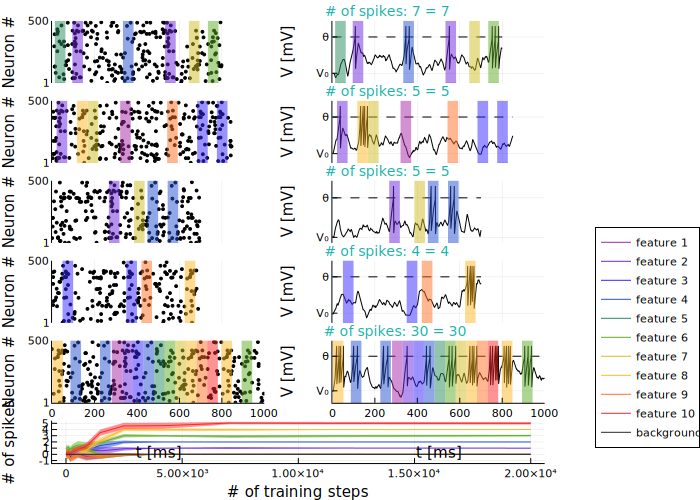

In [13]:
# Input plots
inp_plots = map(test_samples) do s
     p = plot(s.x, reduce_afferents = neur_disp, markersize = sqrt(2), label = "")
     for f ∈ s.features
          plot!(f.duration, color = cols[f.type], label = "")
     end
     return p
end

# Output voltage plots
train_plots = map(zip(test_samples, test_out_a)) do (s, oa)
     p = plot(tmp, s.t, oa.V, label = "")
     for f ∈ s.features
          plot!(f.duration, color = cols[f.type], label = "")
     end
     txt, clr = Tempotrons.get_progress_annotations(length(oa.spikes), N_t = s.y)
     annotate!(xlims(p)[1], ylims(p)[2], text(txt, 10, :left, :bottom, clr))
     return p
end

R_means = hcat([vr.mean for vr ∈ valid_R]...)'
R_stds  = hcat([vr.std  for vr ∈ valid_R]...)'
hist_plot = plot(t_probe, R_means, ribbon = R_stds, 
                 color = cols',
                 labels = hcat([["feature $i" for i in (1:Nᶠ)]..., "background"]...), 
                 xlabel = "# of training steps", 
                 ylabel = "# of spikes", 
                 legend = :outerbottomright)

ip = plot(inp_plots..., layout = (length(inp_plots), 1), link = :x)
tp = plot(train_plots..., layout = (length(train_plots), 1), link = :x)
ps = plot(ip, tp, layout = (1, 2), link = :x)
p = plot(ps, hist_plot, layout = grid(2, 1, heights = [1 - 1 / length(ps), 1 / length(ps)]), 
          link = :x, 
          left_margin = 8mm, right_margin = 8mm, bottom_margin = 12mm, fmt = :svg)

In [14]:
savefig("Results\\AggLabels.svg");
savefig("Results\\AggLabels.png");